In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import networkx as nx
from collections import Counter
from sklearn.preprocessing import MinMaxScaler 
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

Load data

In [210]:
# Read from csv
sig_df = pd.read_csv('Dijet_bb_pt20_50_dw.csv')
bkg_df = pd.read_csv('Dijet_qq_pt20_50_dw.csv')

In [212]:
org_sig_df = sig_df.copy()
org_bkg_df = bkg_df.copy()

In [213]:
# Distinguish signal and background
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Separate Jet 0 and Jet 1 data
sig_df = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_df = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

sig_df = sig_df[(sig_df['Jet0_MC_Match'] == 1) &
                (sig_df['Jet0_MC_Jet_EfB'] > 0.6) &
                (sig_df['Jet0_PT'] > 20000) &
                (sig_df['Jet0_Eta'].between(2.2, 4.4))]
bkg_df = bkg_df[(bkg_df['Jet0_MC_Match'] == 1) &
                (bkg_df['Jet0_MC_Jet_EfB'] < 0.6) &
                (bkg_df['Jet0_MC_Jet_EfD'] < 0.6) &
                (bkg_df['Jet0_PT'] > 20000) &
                (bkg_df['Jet0_Eta'].between(2.2, 4.4))]

# Combine signal and background
combined_df = pd.concat([sig_df, bkg_df])

full_df = combined_df.copy()

In [215]:
daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = [col for col in sig_df.columns if "SVtag" in col]
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

In [216]:
def prepare_features(df, jet_cols, daughter_cols):
    # Duplicate data to lists matching the number of daughters/nodes per jet/row
    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)

    # Convert string values into list of floats
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

# Duplicate single features for each node
df = prepare_features(combined_df, jet_cols, daughter_cols)

In [217]:
# Split data 80:20 w equal parts sig/bkg then shuffle
sig_df = df[df['IsB'] == 1]
bkg_df = df[df['IsB'] == 0]

train_df = pd.concat([sig_df.head(12000), bkg_df.head(12000)]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_df.tail(3000), bkg_df.tail(3000)]).sample(frac=1, random_state=42).reset_index(drop=True)

Plot features data

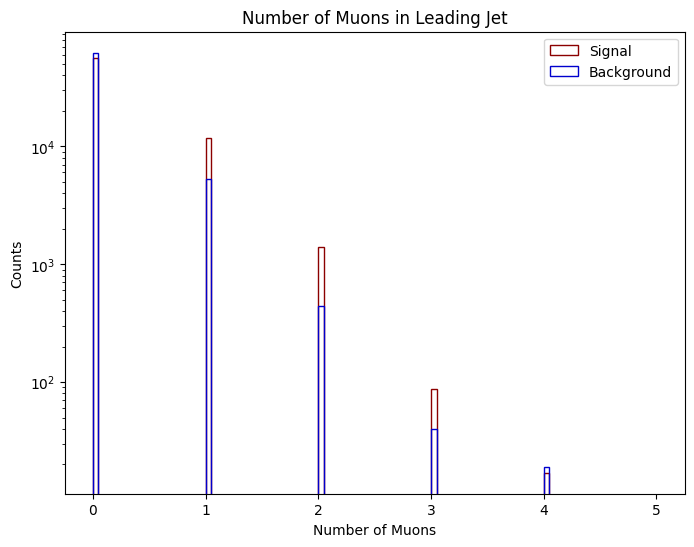

In [218]:
plt.figure(figsize=(8, 6))
plt.hist(sig_df.Jet0_nmuons, label="Signal", range=[0,5], bins=100, histtype='step', color='darkred')
plt.hist(bkg_df.Jet0_nmuons, label="Background", range=[0,5], bins=100, histtype='step', color='mediumblue')
plt.xlabel('Number of Muons')
plt.ylabel("Counts")
plt.yscale('log')
plt.legend(loc='best')
plt.title('Number of Muons in Leading Jet'); 
plt.show()

In [242]:
def normalize_and_plot(col, bins, x_label, y_scale, title):
    sig_list = []
    bkg_list = []

    for i, row in sig_df.iterrows():
        vals = row[col]
        if isinstance(vals, list):
            sig_list.extend(vals)
        else:
            sig_list.append(vals)

    for i, row in bkg_df.iterrows():
        vals = row[col]
        if isinstance(vals, list):
            bkg_list.extend(vals)
        else:
            bkg_list.append(vals)


    sig_array = np.array(sig_list).reshape(-1, 1)
    bkg_array = np.array(bkg_list).reshape(-1, 1)

    combined_data = np.concatenate((sig_array, bkg_array), axis=0)

    scaler = MinMaxScaler().fit(combined_data)

    sig_norm_list = scaler.transform(sig_array)
    bkg_norm_list = scaler.transform(bkg_array)
    
    plt.figure(figsize=(10, 6))
    plt.hist(sig_norm_list, label="Signal", range=[0,1], bins=bins, histtype='step', color='darkred')
    plt.hist(bkg_norm_list, label="Background", range=[0,1], bins=bins, histtype='step', color='mediumblue')
    plt.xlabel(x_label)
    plt.ylabel('Counts')
    plt.yscale(y_scale)
    plt.legend(loc='best')
    plt.title(title); 
    plt.show()

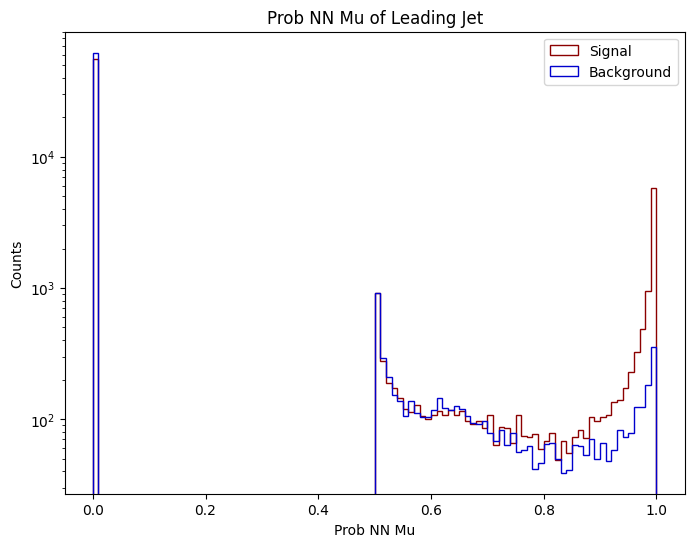

In [220]:
normalize_and_plot('Jet0_muon_ProbNNMu', 100, 'Prob NN Mu', 'log', 'Prob NN Mu of Leading Jet')

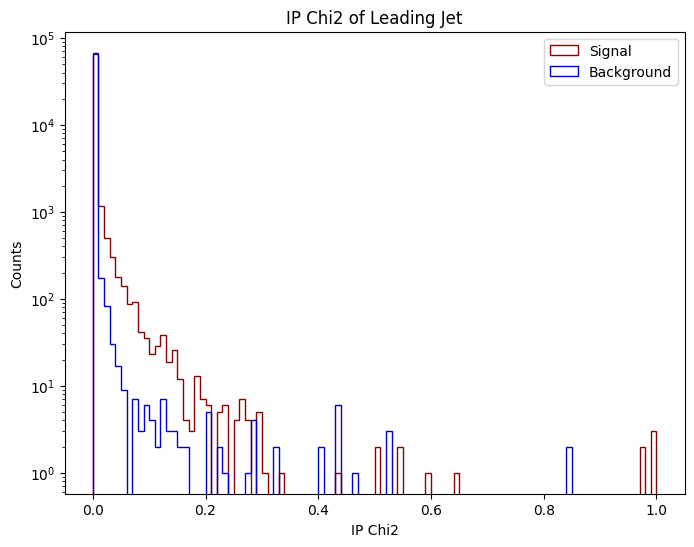

In [221]:
normalize_and_plot('Jet0_muon_IPchi2', 100, 'IP Chi2', 'log', 'IP Chi2 of Leading Jet')

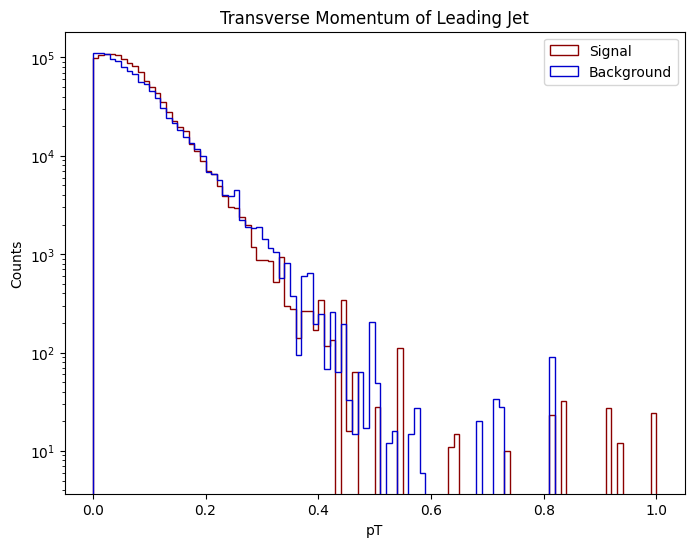

In [222]:
normalize_and_plot('Jet0_PT', 100, 'pT', 'log', 'Transverse Momentum of Leading Jet')

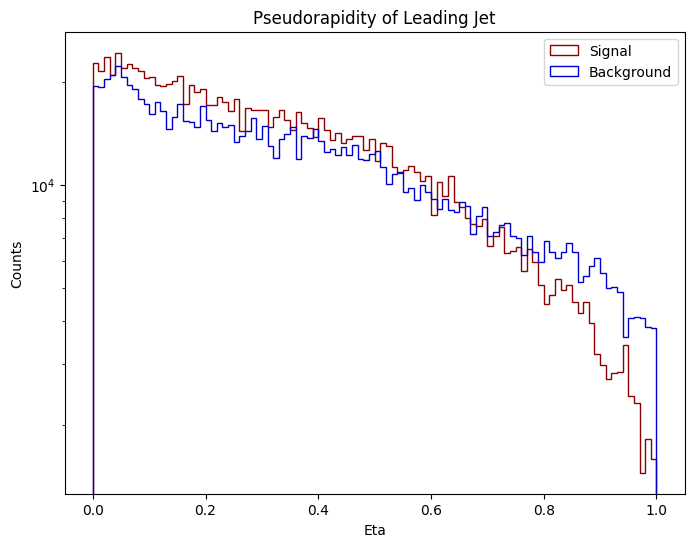

In [223]:
normalize_and_plot('Jet0_Eta', 100, 'Eta', 'log', 'Pseudorapidity of Leading Jet')

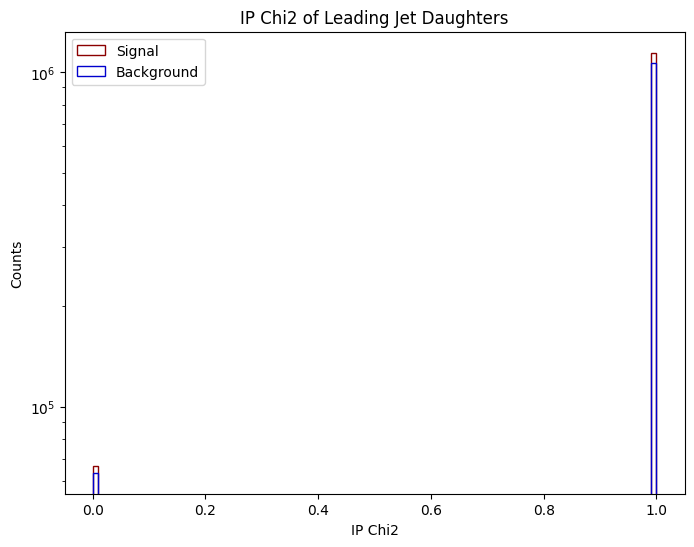

In [224]:
normalize_and_plot('Jet0_Daughters_IPCHI2', 100, 'IP Chi2', 'log', 'IP Chi2 of Leading Jet Daughters')

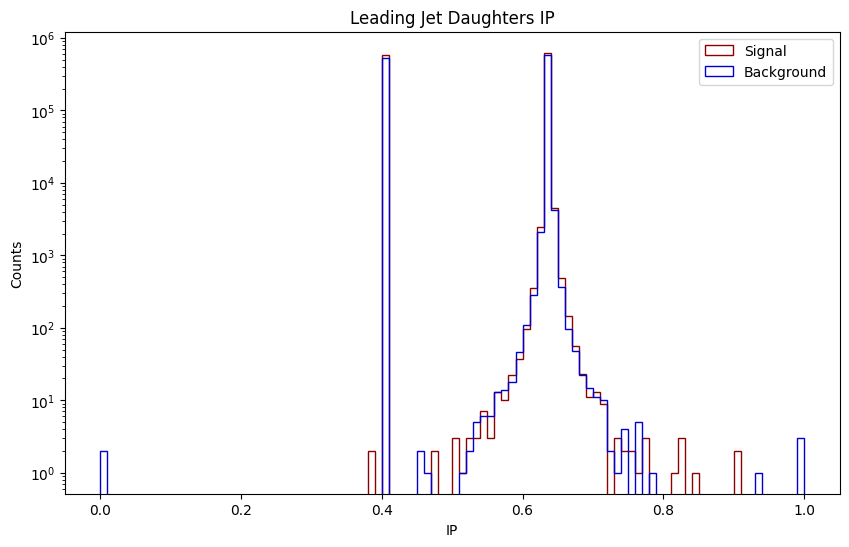

In [243]:
normalize_and_plot('Jet0_Daughters_IP', 100, 'IP', 'log', 'Leading Jet Daughters IP')

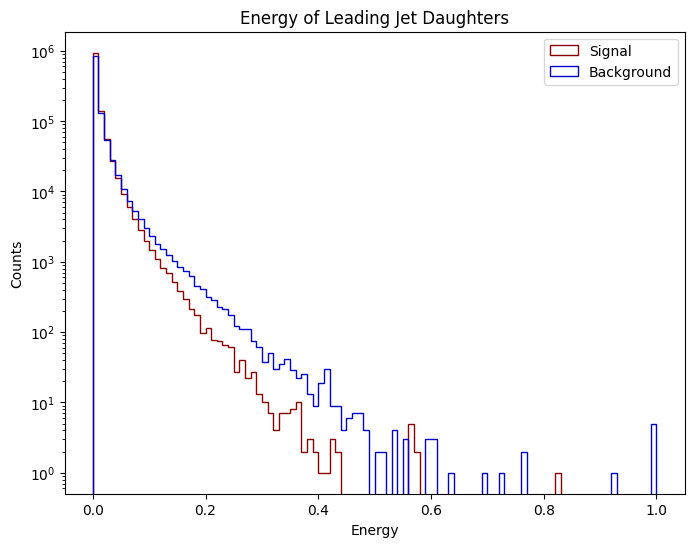

In [226]:
normalize_and_plot('Jet0_Daughters_E', 100, 'Energy', 'log', 'Energy of Leading Jet Daughters')

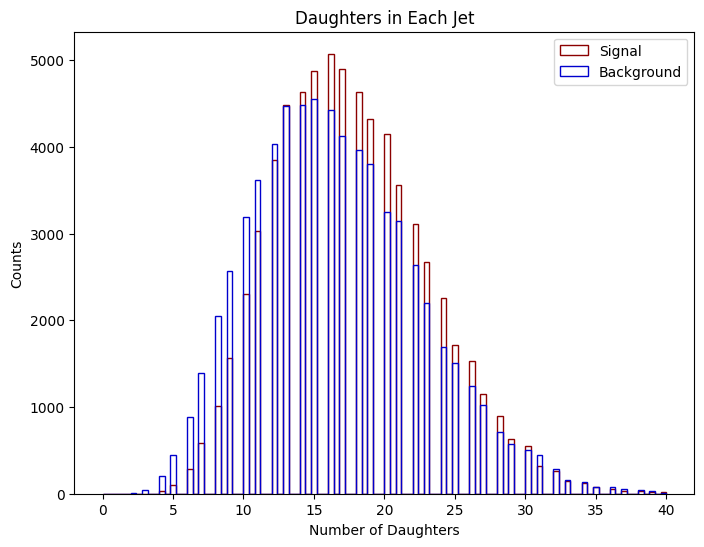

In [227]:
plt.figure(figsize=(8, 6))
plt.hist(sig_df.Jet0_nDaughters, label="Signal", range=[0,40], bins=100, histtype='step', color='darkred')
plt.hist(bkg_df.Jet0_nDaughters, label="Background", range=[0,40], bins=100, histtype='step', color='mediumblue')
plt.xlabel('Number of Daughters')
plt.ylabel("Counts")
plt.legend(loc='best')
plt.title('Daughters in Each Jet'); 
plt.show()

In [228]:
sig_id_list = []
bkg_id_list = []

for i, row in sig_df.iterrows():
    numbers = [float(num) for num in row['Jet0_Daughters_ID']]
    sig_id_list.extend(numbers)

for i, row in bkg_df.iterrows():
    numbers = [float(num) for num in row['Jet0_Daughters_ID']]
    bkg_id_list.extend(numbers)

In [229]:
sig_id_counts = Counter(sig_id_list)
bkg_id_counts = Counter(bkg_id_list)

In [230]:
sig_id_counts

Counter({22.0: 496754,
         211.0: 235952,
         -211.0: 232082,
         -22.0: 66737,
         310.0: 39285,
         321.0: 28977,
         -321.0: 28599,
         -11.0: 14963,
         11.0: 14550,
         111.0: 11397,
         2212.0: 10255,
         -2212.0: 9640,
         -13.0: 5456,
         13.0: 5055,
         -3122.0: 4861,
         3122.0: 4722})

In [231]:
bkg_id_counts

Counter({22.0: 459141,
         211.0: 229267,
         -211.0: 223814,
         -22.0: 63545,
         321.0: 28592,
         -321.0: 27363,
         310.0: 17327,
         2212.0: 17210,
         -2212.0: 16193,
         -11.0: 12551,
         11.0: 12104,
         111.0: 11790,
         -3122.0: 2501,
         3122.0: 2409,
         -13.0: 1114,
         13.0: 945})

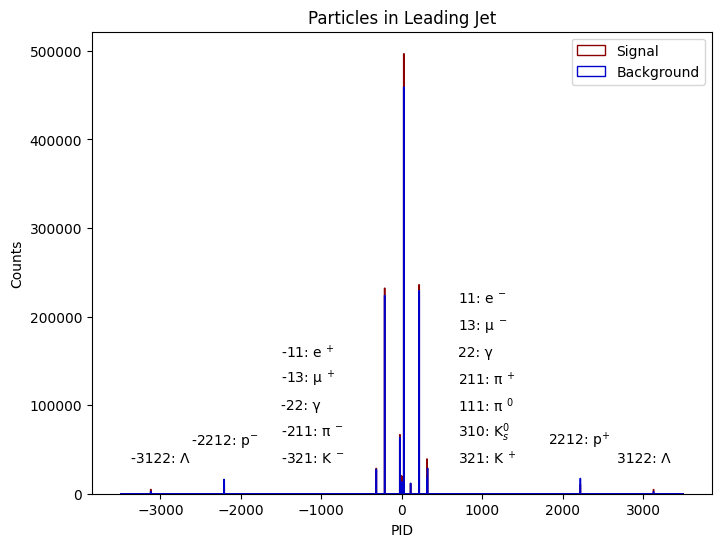

In [232]:
# Plot of Jet 0 Daughters PID (not including some outliers)
plt.figure(figsize=(8, 6))
plt.hist(sig_id_list, label='Signal', bins=1000, range=[-3500,3500], histtype='step', color='darkred')
plt.hist(bkg_id_list, label='Background', bins=1000, range=[-3500,3500], histtype='step', color='mediumblue')

plt.text(-3000, 40000, '-3122: Λ', horizontalalignment='center', verticalalignment='center')
plt.text(-2200, 60000, '-2212: p$^{-}$', horizontalalignment='center', verticalalignment='center')
plt.text(-1500, 40000, '-321: K $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 70000, '-211: π $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 100000, '-22: γ', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 130000, '-13: µ $^{+}$', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 160000, '-11: e $^{+}$', horizontalalignment='left', verticalalignment='center')

plt.text(700, 220000, '11: e $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 190000, '13: µ $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 160000, '22: γ', horizontalalignment='left', verticalalignment='center')
plt.text(700, 130000, '211: π $^{+}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 100000, '111: π $^{0}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 70000, '310: K$^{0}_{s}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 40000, '321: K $^{+}$', horizontalalignment='left', verticalalignment='center')
plt.text(2200, 60000, '2212: p$^{+}$', horizontalalignment='center', verticalalignment='center')
plt.text(3000, 40000, '3122: Λ', horizontalalignment='center', verticalalignment='center')

plt.xlabel('PID');
plt.ylabel('Counts');
plt.title('Particles in Leading Jet');
plt.legend(loc='best');
plt.show()

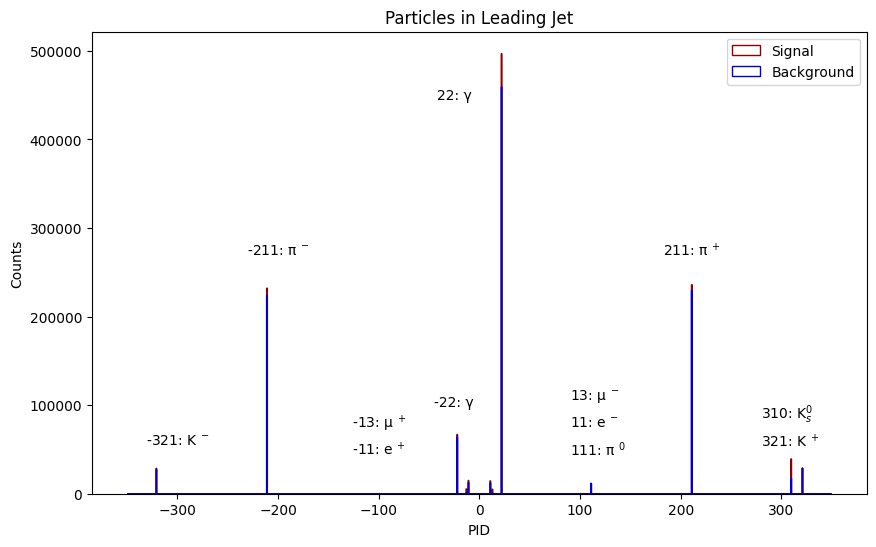

In [237]:
# Plot of Daughters PID in range of pions and kaons
plt.figure(figsize=(10, 6))
plt.hist(sig_id_list, label='Signal', bins=1000, range=[-350,350], histtype='step', color='darkred')
plt.hist(bkg_id_list, label='Background', bins=1000, range=[-350,350], histtype='step', color='mediumblue')

plt.text(-300, 60000, '-321: K $^{-}$', horizontalalignment='center', verticalalignment='center')
plt.text(-200, 275000, '-211: π $^{-}$', horizontalalignment='center', verticalalignment='center')
plt.text(-25, 103000, '-22: γ', horizontalalignment='center', verticalalignment='center')
plt.text(-100, 80000, '-13: µ $^{+}$', horizontalalignment='center', verticalalignment='center')
plt.text(-100, 50000, '-11: e $^{+}$', horizontalalignment='center', verticalalignment='center')

plt.text(90, 80000, '11: e $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(90, 110000, '13: µ $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(-25, 450000, '22: γ', horizontalalignment='center', verticalalignment='center')
plt.text(90, 50000, '111: π $^{0}$', horizontalalignment='left', verticalalignment='center')
plt.text(211, 275000, '211: π $^{+}$', horizontalalignment='center', verticalalignment='center')
plt.text(280, 90000, '310: K$^{0}_{s}$', horizontalalignment='left', verticalalignment='center')
plt.text(280, 60000, '321: K $^{+}$', horizontalalignment='left', verticalalignment='center')

plt.xlabel('PID');
plt.ylabel('Counts');
plt.title('Particles in Leading Jet');
plt.legend(loc='best');
plt.show()

In [234]:
# Split data 80:20 w equal parts sig/bkg then shuffle
train_df = pd.concat([sig_df.head(12000), bkg_df.head(12000)]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_df.tail(3000), bkg_df.tail(3000)]).sample(frac=1, random_state=42).reset_index(drop=True)

daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = [col for col in sig_df.columns if "SVtag" in col]
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

# Create node feature array: [jet][daughter][feature]
def node_features(df):
    features_list = []
    
    for _, row in df.iterrows():
        num_nodes = row['Jet0_nDaughters']
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    return np.array(features_list, dtype=object)

# Create graphs for each jet - orig
def create_data_objects(df, features_array):
    data_objects = []
    for idx, features in enumerate(features_array):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Fully connected edges
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Extract node features
train_features = node_features(train_df)
test_features = node_features(test_df)

# Create graphs for each jet
train_data = create_data_objects(train_df, train_features)
test_data = create_data_objects(test_df, test_features)

# Load Data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [250]:
# Print adjacency matric
G = nx.Graph()
G.add_edges_from(train_loader.dataset[0].edge_index.t().tolist())
A = nx.adjacency_matrix(G)
print(A.todense())

[[0 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 0]]


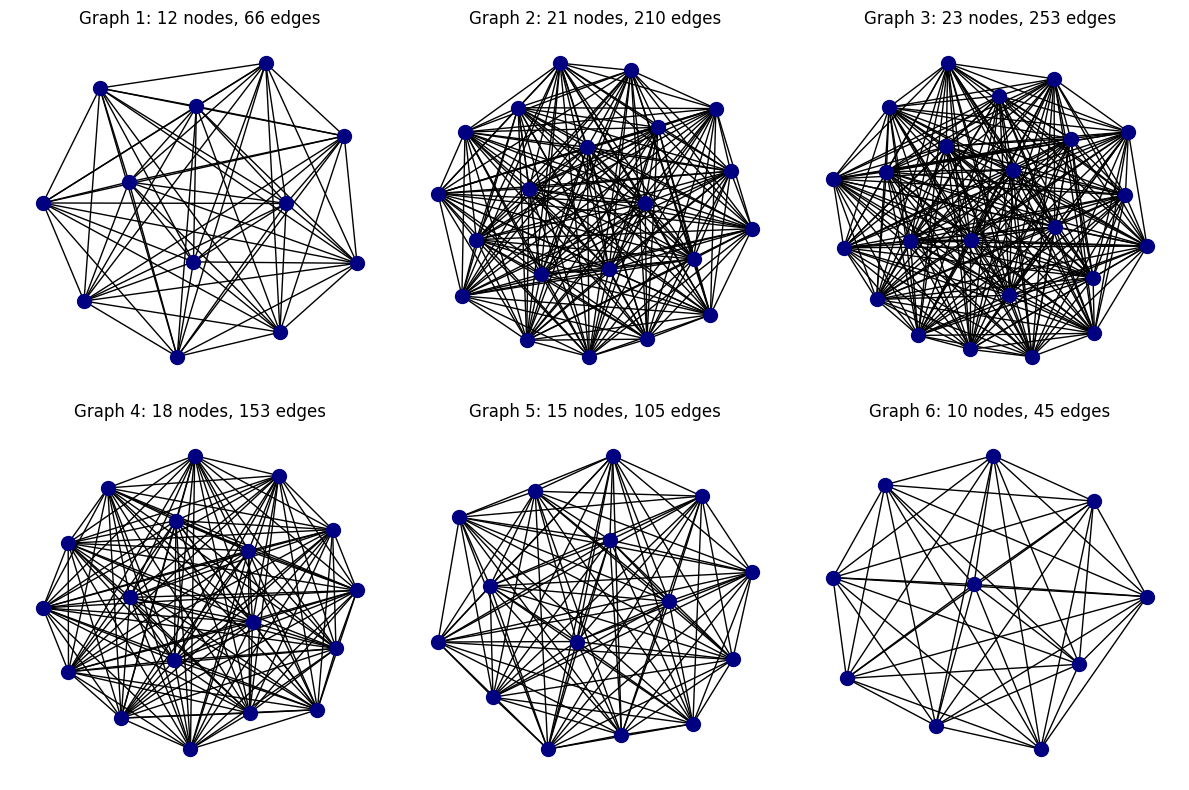

In [236]:
# Visualize some graphs
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, data in enumerate(train_loader.dataset[:6]):
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())

    nx.draw(G, ax=axes[i], node_color='navy', node_size=100)
    
    axes[i].set_title(f"Graph {i+1}: {data.num_nodes} nodes, {data.edge_index.size(1)} edges")

plt.tight_layout()
plt.show()